# Cross-Band RFI-Induced SNR Attenuation Analysis

This notebook evaluates the impact of radio-frequency interference (RFI) on space
communication links operating in the S, X, Ku, K, and Ka bands.

The objective is **comparative analysis**, not regulatory compliance.

The primary metric is the RFI-induced attenuation of link margin:

ΔSNR = SNR₀ − SNRᵢ


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Ensure local package visibility
current_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, "rfi"))

from rfi.scenario import run_multi_entry_rfi_scenario
from rfi.itu_models import (
    compute_thermal_noise_dbw,
    free_space_path_loss_db,
    compute_interference_power_dbw,
    compute_snr_with_interference_db,
    compute_off_axis_gain_s1528_db,
    generate_geometric_sweep,
)


## Victim Link Definitions (by Frequency Band)

Each band is evaluated independently using representative link parameters.
All bands are later subjected to identical interference scenarios.


In [7]:
BAND_CONFIGS = {
    "S-band": {
        "f_ghz": 2.2,
        "d_km": 36000,
        "EIRP_dbw": 30.0,
        "G_rx_db": 32.0,
        "theta_3db": 2.5,
        "T_sys_k": 250.0,
        "B_Hz": 1e6,
    },
    "X-band": {
        "f_ghz": 8.4,
        "d_km": 36000,
        "EIRP_dbw": 32.0,
        "G_rx_db": 38.0,
        "theta_3db": 1.5,
        "T_sys_k": 300.0,
        "B_Hz": 1e6,
    },
    "Ku-band": {
        "f_ghz": 14.0,
        "d_km": 36000,
        "EIRP_dbw": 34.0,
        "G_rx_db": 42.0,
        "theta_3db": 1.2,
        "T_sys_k": 350.0,
        "B_Hz": 1e6,
    },
    "K-band": {
        "f_ghz": 22.0,
        "d_km": 36000,
        "EIRP_dbw": 35.0,
        "G_rx_db": 45.0,
        "theta_3db": 1.0,
        "T_sys_k": 400.0,
        "B_Hz": 1e6,
    },
    "Ka-band": {
        "f_ghz": 32.0,
        "d_km": 36000,
        "EIRP_dbw": 36.0,
        "G_rx_db": 48.0,
        "theta_3db": 0.8,
        "T_sys_k": 450.0,
        "B_Hz": 1e6,
    },
}


## Interference Scenario Definitions

Three interference scenarios are defined with increasing reference interferer
EIRP. Geometry is kept identical across scenarios and bands.


In [8]:
INTERFERENCE_SCENARIOS = {
    "Weak": [
        {
            "EIRP_int_dbw": 10.0,
            "d_km": 3000.0,
            "theta_off_axis_deg": 8.0,
        }
    ],
    "Moderate": [
        {
            "EIRP_int_dbw": 20.0,
            "d_km": 3000.0,
            "theta_off_axis_deg": 8.0,
        }
    ],
    "Strong": [
        {
            "EIRP_int_dbw": 30.0,
            "d_km": 3000.0,
            "theta_off_axis_deg": 8.0,
        }
    ],
}


In [9]:
results = {}

for band_name, band_cfg in BAND_CONFIGS.items():
    res = run_multi_entry_rfi_scenario(
        band_params=band_cfg,
        interferer_list=INTERFERENCE_SCENARIOS["Moderate"],
        time_sim_samples=1000,
    )
    results[band_name] = res


## Baseline SNR Across Frequency Bands

This figure shows the interference-free SNR for each victim link.


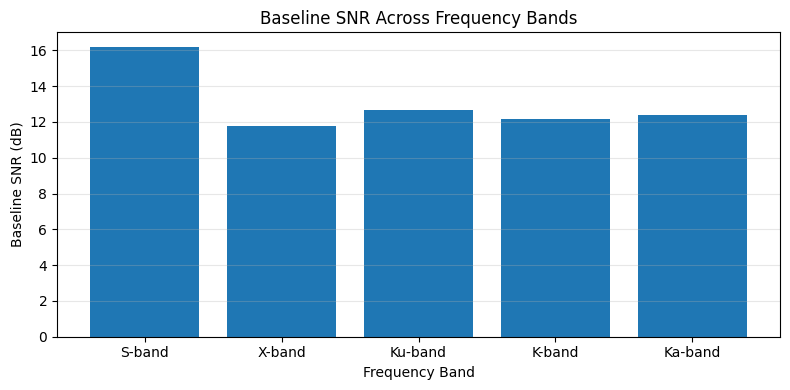

In [10]:
bands = list(results.keys())
baseline_snr = [results[b]["Baseline SNR (dB)"] for b in bands]

plt.figure(figsize=(8, 4))
plt.bar(bands, baseline_snr)
plt.ylabel("Baseline SNR (dB)")
plt.xlabel("Frequency Band")
plt.title("Baseline SNR Across Frequency Bands")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Interference-Induced Attenuation (ΔSNR)

This plot shows the SNR loss caused by the same aggregate interference scenario
applied across all frequency bands.


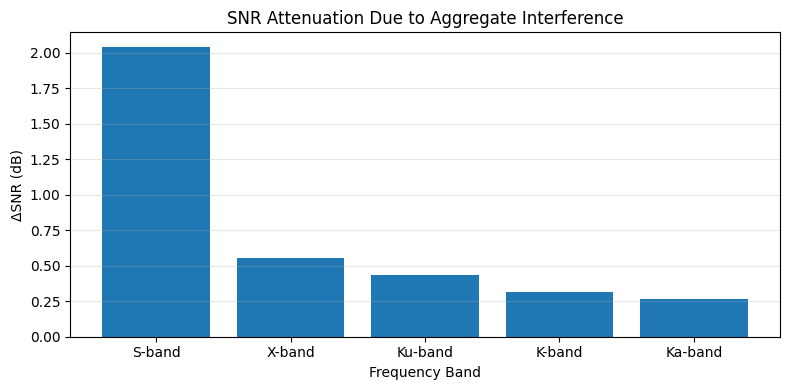

In [11]:
snr_loss = [results[b]["SNR Loss (dB)"] for b in bands]

plt.figure(figsize=(8, 4))
plt.bar(bands, snr_loss)
plt.ylabel("ΔSNR (dB)")
plt.xlabel("Frequency Band")
plt.title("SNR Attenuation Due to Aggregate Interference")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## ΔSNR Across Frequency Bands and Interference Scenarios

This heat map compares RFI-induced attenuation across bands for interference
scenarios with increasing strength.


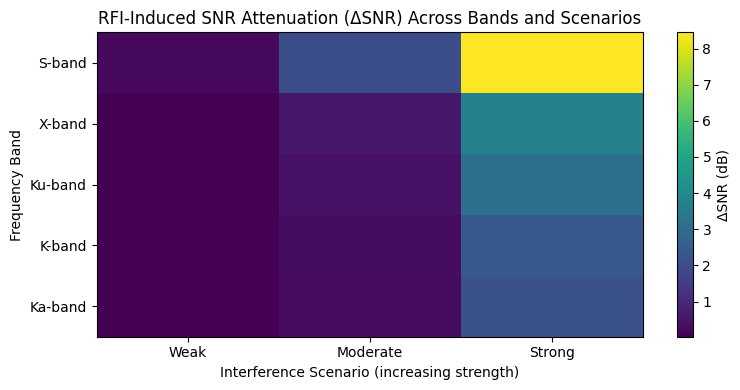

In [12]:
scenario_names = list(INTERFERENCE_SCENARIOS.keys())
scenario_matrix = []

for band_name, band_cfg in BAND_CONFIGS.items():
    row = []
    for scen in scenario_names:
        res = run_multi_entry_rfi_scenario(
            band_params=band_cfg,
            interferer_list=INTERFERENCE_SCENARIOS[scen],
            time_sim_samples=1000,
        )
        row.append(res["SNR Loss (dB)"])
    scenario_matrix.append(row)

scenario_matrix = np.array(scenario_matrix)

plt.figure(figsize=(8, 4))
im = plt.imshow(
    scenario_matrix,
    aspect="auto",
    cmap="viridis",
)

plt.xticks(
    np.arange(len(scenario_names)),
    scenario_names,
)
plt.yticks(
    np.arange(len(BAND_CONFIGS)),
    list(BAND_CONFIGS.keys()),
)

plt.xlabel("Interference Scenario (increasing strength)")
plt.ylabel("Frequency Band")
plt.title("RFI-Induced SNR Attenuation (ΔSNR) Across Bands and Scenarios")

cbar = plt.colorbar(im)
cbar.set_label("ΔSNR (dB)")

plt.tight_layout()
plt.show()


## Interference-Induced Attenuation (ΔSNR)

This figure shows the degradation in signal-to-noise ratio caused by the same
aggregate interference scenario applied across all frequency bands.

The quantity ΔSNR represents the additional link-margin attenuation introduced
by radio-frequency interference.


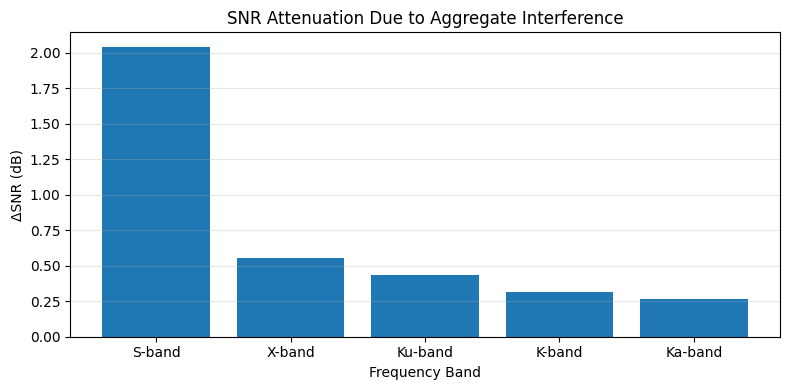

In [13]:
bands = list(results.keys())
snr_loss = [results[b]["SNR Loss (dB)"] for b in bands]

plt.figure(figsize=(8, 4))
plt.bar(bands, snr_loss)

plt.xlabel("Frequency Band")
plt.ylabel("ΔSNR (dB)")
plt.title("SNR Attenuation Due to Aggregate Interference")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Sensitivity of ΔSNR to Interferer EIRP

In this analysis, the interferer equivalent isotropically radiated power (EIRP)
is swept over a range of reference values while all other parameters (geometry,
antenna patterns, bandwidth, and noise temperature) are held constant.

The purpose of this sweep is to study **relative sensitivity** of each frequency
band to increasing interference strength, rather than to evaluate absolute
regulatory limits.


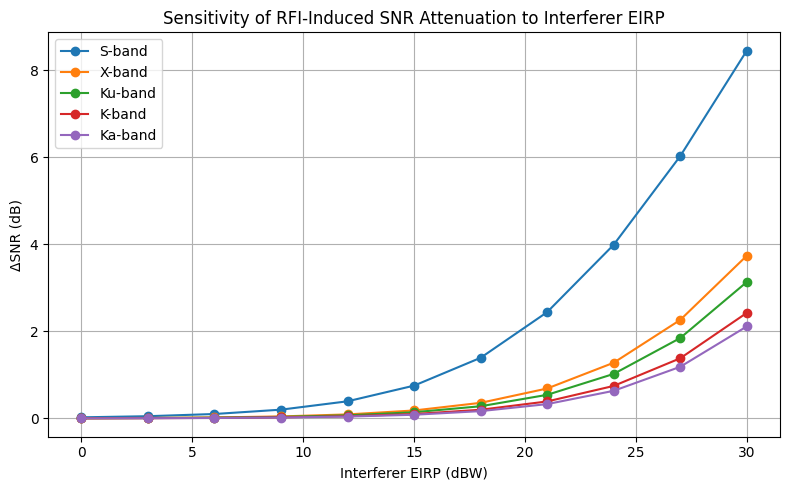

In [14]:
# Define EIRP sweep (dummy reference values)
eirp_sweep_dbw = np.linspace(0, 30, 11)  # 0 to 30 dBW

# Container for results
snr_loss_vs_eirp = {band: [] for band in BAND_CONFIGS.keys()}

# Sweep EIRP for each band
for eirp in eirp_sweep_dbw:
    interferers = [
        {
            "EIRP_int_dbw": eirp,
            "d_km": 3000.0,
            "theta_off_axis_deg": 8.0,
        }
    ]

    for band_name, band_cfg in BAND_CONFIGS.items():
        res = run_multi_entry_rfi_scenario(
            band_params=band_cfg,
            interferer_list=interferers,
            time_sim_samples=1000,
        )
        snr_loss_vs_eirp[band_name].append(res["SNR Loss (dB)"])

# Plot
plt.figure(figsize=(8, 5))

for band_name, snr_losses in snr_loss_vs_eirp.items():
    plt.plot(eirp_sweep_dbw, snr_losses, marker="o", label=band_name)

plt.xlabel("Interferer EIRP (dBW)")
plt.ylabel("ΔSNR (dB)")
plt.title("Sensitivity of RFI-Induced SNR Attenuation to Interferer EIRP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
